In [2]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd
import numpy as np
import random
import scipy.sparse as sp
from scipy import stats

import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)

from tqdm.autonotebook import tqdm, trange

In [3]:
SEED = 42
if SEED is not None:
    np.random.seed(SEED)
    random.seed(SEED)

# 1. Датасет
Выбрал [movielens](https://grouplens.org/datasets/movielens/), так как он стал почти классикой, встречается почти во всех статьях  

Также очень удобно, что есть нексколько размеров, удобнее вначале тестировать на небольшом размере, а затем прогнать на большем  

На счет разделения на train/test: давайте для каждого пользователя поделим оцененные им фильмы в хронологическом порядке (т.е. первые 3/4 оценок отнесем в train, а оставшуюся четверть — в test). 

Плюсы: 
* train и test состоят из одинаковых пользователей (если предварительно оставить только тех, кто сделал не меньше 4 оценок)
* не мешаем по времени, можем применять различные техники для затухания

Минусы:
* не глобальная граница по времени (т.е. если разбить на train/test как раньше/после 01.01.2015, например) $\Longrightarrow$ чуточку заглядываем в будущее

In [4]:
from pathlib import Path

from reco_utils.dataset import movielens
from reco_utils.dataset.python_splitters import python_stratified_split, python_chrono_split

In [5]:
# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'

In [6]:
data_path = Path('.')
ratings = movielens.load_pandas_df(MOVIELENS_DATA_SIZE, ('userID', 'itemID', 'rating', 'timestamp'),
            title_col='title',
            local_cache_path=data_path)

movie_info = movielens.load_item_df(title_col='title', genres_col='genres', local_cache_path=data_path)

In [7]:
ratings.head()

,userID,itemID,rating,timestamp,title
0,196,242,3.0,881250949,Kolya (1996)
1,63,242,3.0,875747190,Kolya (1996)
2,226,242,5.0,883888671,Kolya (1996)
3,154,242,3.0,879138235,Kolya (1996)
4,306,242,5.0,876503793,Kolya (1996)


In [8]:
train, test = python_chrono_split(ratings, ratio=0.75, col_user='userID', col_item='itemID', col_timestamp='timestamp', )

In [9]:
test = test[test['itemID'].isin(train['itemID'].unique())]

train = train[train['itemID'].isin(test['itemID'].unique())]

In [10]:
train.shape, test.shape

((74635, 5), (24895, 5))

In [11]:
train.head()

,userID,itemID,rating,timestamp,title
52987,1,168,5.0,874965478,Monty Python and the Holy Grail (1974)
26237,1,172,5.0,874965478,"Empire Strikes Back, The (1980)"
11522,1,165,5.0,874965518,Jean de Florette (1986)
49933,1,156,4.0,874965556,Reservoir Dogs (1992)
75353,1,166,5.0,874965677,Manon of the Spring (Manon des sources) (1986)


In [12]:
train_times = train.groupby(by='userID', as_index=False)['timestamp'].max()
test_times = test.groupby(by='userID', as_index=False)['timestamp'].min()

merged_times = train_times.merge(test_times, on='userID')

merged_times.head()

,userID,timestamp_x,timestamp_y
0,1,878542772,878542791
1,2,888552084,888552084
2,3,889237315,889237455
3,4,892003525,892003526
4,5,875721019,875721167


In [13]:
(merged_times['timestamp_x'] > merged_times['timestamp_y']).sum()

0

**нет пересечений по времени:** для каждого пользователя его первая оценка из test'а позже последней оценки из train'а

In [14]:
implicit_ratings_train = train.loc[(train['rating'] >= 4)]
implicit_ratings_test = test.loc[(test['rating'] >= 4)]

In [15]:
users = implicit_ratings_train["userID"]
movies = implicit_ratings_train["itemID"]
user_item = sp.coo_matrix((np.ones_like(users), (users, movies)))
user_item_t_csr = user_item.T.tocsr()
user_item_csr = user_item.tocsr()

In [16]:
users_test = implicit_ratings_test["userID"]
movies_test = implicit_ratings_test["itemID"]
user_item_test = sp.coo_matrix((np.ones_like(users_test), (users_test, movies_test)))
user_item_test_csr = user_item_test.tocsr()

# 2-3. Сравнение
Давайте попробуем много моделек, и для каждой модели будем считать следующие метрики:
* map_at_k
* ndcg_at_k
* precision_at_k
* recall_at_k 

для $k \in [3, 5, 10]$


А также покажем похожие фильмы для:
* истории игрушек
* звездных войн

И предсказания для конкретных пользователей:
* 96, 734
(их история чуть ниже)

In [17]:
N_FACTORS = 64
TOP_K = 10
MOVIES_TO_SIMILAR = [1, 50]
USERS_TO_RECOMMEND = [96, 734]

In [18]:
for user_to_recommend in USERS_TO_RECOMMEND:
    print(f'История просмотров пользователя: {user_to_recommend}')
    display(train[train['userID'] == user_to_recommend].sample(10))

История просмотров пользователя: 96


,userID,itemID,rating,timestamp,title
18653,96,195,5.0,884403159,"Terminator, The (1984)"
95539,96,645,5.0,884403020,Paris Is Burning (1990)
92055,96,519,4.0,884402896,"Treasure of the Sierra Madre, The (1948)"
29775,96,127,5.0,884403214,"Godfather, The (1972)"
36675,96,484,5.0,884402860,"Maltese Falcon, The (1941)"
24791,96,79,4.0,884403500,"Fugitive, The (1993)"
654,96,474,4.0,884403095,Dr. Strangelove or: How I Learned to Stop Worr...
19017,96,200,5.0,884403215,"Shining, The (1980)"
2985,96,144,4.0,884403250,Die Hard (1988)
49852,96,156,4.0,884402860,Reservoir Dogs (1992)


История просмотров пользователя: 734


,userID,itemID,rating,timestamp,title
16650,734,132,3.0,891022212,"Wizard of Oz, The (1939)"
39507,734,751,4.0,891021937,Tomorrow Never Dies (1997)
37617,734,204,4.0,891022938,Back to the Future (1985)
75383,734,166,3.0,891022849,Manon of the Spring (Manon des sources) (1986)
35402,734,82,4.0,891022704,Jurassic Park (1993)
5346,734,193,4.0,891025340,"Right Stuff, The (1983)"
77801,734,582,2.0,891022684,"Piano, The (1993)"
33413,734,56,1.0,891022752,Pulp Fiction (1994)
10251,734,288,4.0,891022311,Scream (1996)
3060,734,144,2.0,891023019,Die Hard (1988)


In [19]:
from reco_utils.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

def test_model_perfomance(model_predictions, get_similar_items_fn=None):
    if get_similar_items_fn:
        print('Похожие фильмы:')
        for movie_id in MOVIES_TO_SIMILAR:
            display(movie_info.set_index('itemID').loc[get_similar_items_fn(movie_id)])
        print('\n')
        
    for user_to_recommend in USERS_TO_RECOMMEND:
        print(f'Рекомендации для пользователя: {user_to_recommend}')
        display(model_predictions[model_predictions['userID']==user_to_recommend].merge(movie_info, on='itemID'))
    
    model_perfomance = {}
    
    for k in [3, 5, 10]:
        for metric in map_at_k, ndcg_at_k, precision_at_k, recall_at_k:
            metric_name = f"{metric.__name__.rpartition('_')[0]}_{k}"
            metric_value = metric(rating_true=test, rating_pred=model_predictions, k=k)
            model_perfomance[metric_name] = metric_value
    return model_perfomance

In [20]:
def get_metrics(groups) -> pd.DataFrame:
    metrics =  pd.DataFrame.from_records(groups, columns=groups.keys(), index=list(all_metrics.values())[0].keys())
    metrics.index.name = 'metric'
    return metrics

def get_ate(groups, control_name) -> pd.DataFrame:
    """Get Average Treatment Effect
    groups - dictionary where keys - names of models, values - dicts of pairs <metric_name>, <metric_value>
    control_name - name of baseline model
    
    return pd.DataFrame (rows corresponds to metrics, cols corresponds to models and ATE with respect to control)
    """
    metrics = get_metrics(groups)
    return metrics.subtract(metrics[control_name], axis='index').drop(columns=control_name) * 100


all_metrics = {}

# 2. Готовые модели
## 2.1 BayesianPersonalizedRanking [implicit](https://implicit.readthedocs.io/en/latest/bpr.html)

In [21]:
import implicit

In [22]:
model = implicit.bpr.BayesianPersonalizedRanking(factors=N_FACTORS, iterations=100)

In [23]:
model.fit(user_item_t_csr)

In [24]:
ratings_predictions = model.recommend_all(user_item_csr, N=TOP_K)

In [25]:
predictions = pd.DataFrame(np.arange(ratings_predictions.shape[0]), columns=['userID'])

predictions['itemID'] = ratings_predictions.tolist()

predictions = predictions[predictions['userID'].isin(users.unique())]

predictions = predictions.explode('itemID', ignore_index=True)

predictions['itemID'] = predictions['itemID'].astype(np.int64)

predictions['prediction'] = TOP_K - predictions.index % TOP_K

In [26]:
get_similars_fn = lambda item_id: np.array(model.similar_items(item_id), dtype=np.int)[:, 0]

In [27]:
all_metrics['bpr_implicit'] = test_model_perfomance(predictions, get_similar_items_fn=get_similars_fn)

Похожие фильмы:


,title,genres
itemID,,
1,Toy Story (1995),Animation|Children's|Comedy
596,"Hunchback of Notre Dame, The (1996)",Animation|Children's|Musical
588,Beauty and the Beast (1991),Animation|Children's|Musical
15,Mr. Holland's Opus (1995),Drama
477,Matilda (1996),Children's|Comedy
471,Courage Under Fire (1996),Drama|War
408,"Close Shave, A (1995)",Animation|Comedy|Thriller
845,That Thing You Do! (1996),Comedy
222,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi


,title,genres
itemID,,
50,Star Wars (1977),Action|Adventure|Romance|Sci-Fi|War
181,Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
172,"Empire Strikes Back, The (1980)",Action|Adventure|Drama|Romance|Sci-Fi|War
1216,Kissed (1996),Romance
596,"Hunchback of Notre Dame, The (1996)",Animation|Children's|Musical
1167,"Sum of Us, The (1994)",Comedy
222,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi
999,Clean Slate (1994),Comedy
257,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi




Рекомендации для пользователя: 96


,userID,itemID,prediction,title,genres
0,96,176,10,Aliens (1986),Action|Sci-Fi|Thriller|War
1,96,180,9,Apocalypse Now (1979),Drama|War
2,96,172,8,"Empire Strikes Back, The (1980)",Action|Adventure|Drama|Romance|Sci-Fi|War
3,96,135,7,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller
4,96,12,6,"Usual Suspects, The (1995)",Crime|Thriller
5,96,179,5,"Clockwork Orange, A (1971)",Sci-Fi
6,96,357,4,One Flew Over the Cuckoo's Nest (1975),Drama
7,96,191,3,Amadeus (1984),Drama|Mystery
8,96,185,2,Psycho (1960),Horror|Romance|Thriller
9,96,479,1,Vertigo (1958),Mystery|Thriller


Рекомендации для пользователя: 734


,userID,itemID,prediction,title,genres
0,734,133,10,Gone with the Wind (1939),Drama|Romance|War
1,734,496,9,It's a Wonderful Life (1946),Drama
2,734,216,8,When Harry Met Sally... (1989),Comedy|Romance
3,734,427,7,To Kill a Mockingbird (1962),Drama
4,734,378,6,Miracle on 34th Street (1994),Drama
5,734,487,5,Roman Holiday (1953),Comedy|Romance
6,734,136,4,Mr. Smith Goes to Washington (1939),Drama
7,734,95,3,Aladdin (1992),Animation|Children's|Comedy|Musical
8,734,69,2,Forrest Gump (1994),Comedy|Romance|War
9,734,131,1,Breakfast at Tiffany's (1961),Drama|Romance


## 2.2 Simple Algorithm for Recommendation (SAR)
Similarity-based algorithm for implicit feedback dataset

In [28]:
from reco_utils.recommender.sar import SAR

In [29]:
model = SAR(
    col_user="userID",
    col_item="itemID",
    col_rating="rating",
    col_timestamp="timestamp",
    similarity_type="jaccard", 
    time_decay_coefficient=30, 
    timedecay_formula=True,
    normalize=True
)

In [30]:
model.fit(train)

In [31]:
def get_similars(item_id):
    items = pd.DataFrame(dict(itemID=[item_id]))
    return np.insert(model.get_item_based_topk(items, top_k=TOP_K - 1)['itemID'].values, 0, item_id)

In [32]:
top_k = model.recommend_k_items(test, remove_seen=True, top_k=TOP_K)

In [33]:
all_metrics['sar'] = test_model_perfomance(top_k, get_similar_items_fn=get_similars)

Похожие фильмы:


,title,genres
itemID,,
1,Toy Story (1995),Animation|Children's|Comedy
50,Star Wars (1977),Action|Adventure|Romance|Sci-Fi|War
181,Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
121,Independence Day (ID4) (1996),Action|Sci-Fi|War
117,"Rock, The (1996)",Action|Adventure|Thriller
100,Fargo (1996),Crime|Drama|Thriller
7,Twelve Monkeys (1995),Drama|Sci-Fi
237,Jerry Maguire (1996),Drama|Romance
222,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi


,title,genres
itemID,,
50,Star Wars (1977),Action|Adventure|Romance|Sci-Fi|War
181,Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
174,Raiders of the Lost Ark (1981),Action|Adventure
1,Toy Story (1995),Animation|Children's|Comedy
172,"Empire Strikes Back, The (1980)",Action|Adventure|Drama|Romance|Sci-Fi|War
100,Fargo (1996),Crime|Drama|Thriller
127,"Godfather, The (1972)",Action|Crime|Drama
121,Independence Day (ID4) (1996),Action|Sci-Fi|War
98,"Silence of the Lambs, The (1991)",Drama|Thriller




Рекомендации для пользователя: 96


,userID,itemID,prediction,title,genres
0,96,204,4.062122,Back to the Future (1985),Comedy|Sci-Fi
1,96,172,4.032116,"Empire Strikes Back, The (1980)",Action|Adventure|Drama|Romance|Sci-Fi|War
2,96,69,4.002916,Forrest Gump (1994),Comedy|Romance|War
3,96,168,3.825309,Monty Python and the Holy Grail (1974),Comedy
4,96,176,3.790867,Aliens (1986),Action|Sci-Fi|Thriller|War
5,96,22,3.746808,Braveheart (1995),Action|Drama|War
6,96,135,3.721178,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller
7,96,210,3.638830,Indiana Jones and the Last Crusade (1989),Action|Adventure
8,96,191,3.621603,Amadeus (1984),Drama|Mystery
9,96,96,3.615755,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller


Рекомендации для пользователя: 734


,userID,itemID,prediction,title,genres
0,734,69,3.496741,Forrest Gump (1994),Comedy|Romance|War
1,734,216,3.273639,When Harry Met Sally... (1989),Comedy|Romance
2,734,168,3.273239,Monty Python and the Holy Grail (1974),Comedy
3,734,79,3.266228,"Fugitive, The (1993)",Action|Thriller
4,734,195,3.252656,"Terminator, The (1984)",Action|Sci-Fi|Thriller
5,734,191,3.166187,Amadeus (1984),Drama|Mystery
6,734,89,3.144103,Blade Runner (1982),Film-Noir|Sci-Fi
7,734,135,3.132174,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller
8,734,196,3.077753,Dead Poets Society (1989),Drama
9,734,234,3.072534,Jaws (1975),Action|Horror


## 2.3 FastAI Embedding Dot Bias (FAST)
General purpose algorithm with embeddings and biases for users and items

In [34]:
import torch, fastai
from fastai.collab import EmbeddingDotBias, collab_learner, CollabDataBunch, load_learner
from reco_utils.recommender.fastai.fastai_utils import cartesian_product, score

In [35]:
USER, ITEM, RATING, TIMESTAMP, PREDICTION, TITLE = 'userID', 'itemID', 'rating', 'timestamp', 'prediction', 'title'

data = CollabDataBunch.from_df(train, user_name=USER, item_name=ITEM, rating_name=RATING, valid_pct=0)

learn = collab_learner(data, n_factors=N_FACTORS, y_range=[0,5.5], wd=1e-1)
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 64)
  (i_weight): Embedding(1460, 64)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1460, 1)
)

In [36]:
learn.fit_one_cycle(5, max_lr=5e-3)

learn.export('movielens_model.pkl')

learner = load_learner(path=".", fname='movielens_model.pkl')

epoch,train_loss,valid_loss,time
1,0.934183,,00:03
2,0.838360,,00:03
3,0.733961,,00:03
4,0.539142,,00:03
5,0.416570,,00:04


In [37]:
total_users, total_items = learner.data.train_ds.x.classes.values()
total_items = total_items[1:]
total_users = total_users[1:]

In [38]:
test_users = test[USER].unique()
test_users = np.intersect1d(test_users, total_users)

In [39]:
users_items = cartesian_product(np.array(test_users),np.array(total_items))
users_items = pd.DataFrame(users_items, columns=[USER,ITEM])

In [40]:
training_removed = pd.merge(users_items, train.astype(str), on=[USER, ITEM], how='left')
training_removed = training_removed[training_removed[RATING].isna()][[USER, ITEM]]

In [41]:
top_k_scores = score(learner, 
                     test_df=training_removed,
                     user_col=USER, 
                     item_col=ITEM, 
                     prediction_col=PREDICTION)

top_k_scores['userID'], top_k_scores['itemID'] = top_k_scores['userID'].astype(np.int), top_k_scores['itemID'].astype(np.int)

In [42]:
all_metrics['fastai'] = test_model_perfomance(top_k_scores)

Рекомендации для пользователя: 96


,userID,itemID,prediction,title,genres
0,96,357,4.639046,One Flew Over the Cuckoo's Nest (1975),Drama
1,96,169,4.570015,"Wrong Trousers, The (1993)",Animation|Comedy
2,96,100,4.547295,Fargo (1996),Crime|Drama|Thriller
3,96,603,4.539406,Rear Window (1954),Mystery|Thriller
4,96,12,4.536561,"Usual Suspects, The (1995)",Crime|Thriller
...,...,...,...,...,...
1412,96,976,1.762360,Solo (1996),Action|Sci-Fi|Thriller
1413,96,1052,1.750606,Dracula: Dead and Loving It (1995),Comedy|Horror
1414,96,688,1.743105,Leave It to Beaver (1997),Comedy
1415,96,457,1.666336,Free Willy 3: The Rescue (1997),Adventure|Children's|Drama


Рекомендации для пользователя: 734


,userID,itemID,prediction,title,genres
0,734,496,4.257504,It's a Wonderful Life (1946),Drama
1,734,71,4.235503,"Lion King, The (1994)",Animation|Children's|Musical
2,734,133,4.190441,Gone with the Wind (1939),Drama|Romance|War
3,734,588,4.182355,Beauty and the Beast (1991),Animation|Children's|Musical
4,734,378,4.134554,Miracle on 34th Street (1994),Drama
...,...,...,...,...,...
1406,734,243,2.051993,Jungle2Jungle (1997),Children's|Comedy
1407,734,260,2.033602,Event Horizon (1997),Action|Mystery|Sci-Fi|Thriller
1408,734,352,2.025604,Spice World (1997),Comedy|Musical
1409,734,424,2.008950,Children of the Corn: The Gathering (1996),Horror


## 2.4 LightGCN
Deep learning algorithm which simplifies the design of GCN for predicting implicit feedback

In [43]:
from reco_utils.recommender.deeprec.models.graphrec.lightgcn import LightGCN
from reco_utils.recommender.deeprec.DataModel.ImplicitCF import ImplicitCF
from reco_utils.recommender.deeprec.deeprec_utils import prepare_hparams

In [44]:
data = ImplicitCF(train=train, test=test, seed=SEED)

In [45]:
hparams = prepare_hparams('lightgcn.yaml',
                          n_layers=3,
                          batch_size=1024,
                          epochs=10,
                          learning_rate=0.005,
                          eval_epoch=5,
                          top_k=TOP_K,
                         )

In [46]:
model = LightGCN(hparams, data, seed=SEED)

Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.


In [47]:
model.fit()

Epoch 1 (train)55.6s: train loss = 0.46719 = (mf)0.46694 + (embed)0.00025
Epoch 2 (train)53.9s: train loss = 0.26214 = (mf)0.26144 + (embed)0.00070
Epoch 3 (train)55.1s: train loss = 0.23399 = (mf)0.23310 + (embed)0.00089
Epoch 4 (train)52.4s: train loss = 0.22238 = (mf)0.22133 + (embed)0.00105
Epoch 5 (train)55.2s + (eval)0.7s: train loss = 0.21181 = (mf)0.21065 + (embed)0.00116, recall = 0.07952, ndcg = 0.16029, precision = 0.13987, map = 0.03928
Epoch 6 (train)53.6s: train loss = 0.20170 = (mf)0.20042 + (embed)0.00128
Epoch 7 (train)52.9s: train loss = 0.19638 = (mf)0.19499 + (embed)0.00139
Epoch 8 (train)50.4s: train loss = 0.18238 = (mf)0.18085 + (embed)0.00153
Epoch 9 (train)50.8s: train loss = 0.17405 = (mf)0.17237 + (embed)0.00168
Epoch 10 (train)54.1s + (eval)0.6s: train loss = 0.16701 = (mf)0.16518 + (embed)0.00183, recall = 0.08903, ndcg = 0.17527, precision = 0.15885, map = 0.04243


In [48]:
topk_scores = model.recommend_k_items(test, top_k=TOP_K, remove_seen=True)

topk_scores.head()

,userID,itemID,prediction
0,1,100,7.198858
1,1,222,6.106092
2,1,210,5.898962
3,1,318,5.664747
4,1,405,5.605955


In [49]:
all_metrics['LightGCN'] = test_model_perfomance(topk_scores)

Рекомендации для пользователя: 96


,userID,itemID,prediction,title,genres
0,96,172,6.883931,"Empire Strikes Back, The (1980)",Action|Adventure|Drama|Romance|Sci-Fi|War
1,96,168,6.771693,Monty Python and the Holy Grail (1974),Comedy
2,96,204,6.468428,Back to the Future (1985),Comedy|Sci-Fi
3,96,191,6.196159,Amadeus (1984),Drama|Mystery
4,96,357,6.163936,One Flew Over the Cuckoo's Nest (1975),Drama
5,96,135,6.104322,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller
6,96,176,6.090839,Aliens (1986),Action|Sci-Fi|Thriller|War
7,96,100,6.084259,Fargo (1996),Crime|Drama|Thriller
8,96,496,6.077539,It's a Wonderful Life (1946),Drama
9,96,28,6.028249,Apollo 13 (1995),Action|Drama|Thriller


Рекомендации для пользователя: 734


,userID,itemID,prediction,title,genres
0,734,100,7.044676,Fargo (1996),Crime|Drama|Thriller
1,734,181,6.693451,Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
2,734,168,6.648169,Monty Python and the Holy Grail (1974),Comedy
3,734,127,6.301153,"Godfather, The (1972)",Action|Crime|Drama
4,734,183,6.299028,Alien (1979),Action|Horror|Sci-Fi|Thriller
5,734,79,6.276914,"Fugitive, The (1993)",Action|Thriller
6,734,357,6.103050,One Flew Over the Cuckoo's Nest (1975),Drama
7,734,286,6.101472,"English Patient, The (1996)",Drama|Romance|War
8,734,64,6.066368,"Shawshank Redemption, The (1994)",Drama
9,734,191,6.019268,Amadeus (1984),Drama|Mystery


## 2.5 Neural Collaborative Filtering (NCF)
Deep learning algorithm with enhanced performance for implicit feedback

In [50]:
from reco_utils.recommender.ncf.ncf_singlenode import NCF
from reco_utils.recommender.ncf.dataset import Dataset as NCFDataset

In [51]:
data = NCFDataset(train=train, test=test, seed=SEED)

In [52]:
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=50,
    batch_size=256,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

In [53]:
model.fit(data)

In [54]:
users, items, preds = [], [], []
item = list(train.itemID.unique())
for user in train.userID.unique():
    user = [user] * len(item) 
    users.extend(user)
    items.extend(item)
    preds.extend(list(model.predict(user, item, is_list=True)))

all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)
all_predictions = all_predictions.sort_values(['userID','prediction'],ascending=False).groupby('userID').head(TOP_K).drop(columns=['timestamp', 'title'])

In [55]:
all_metrics['NCF'] = test_model_perfomance(all_predictions)

Рекомендации для пользователя: 96


,userID,itemID,prediction,title,genres
0,96,168,0.987836,Monty Python and the Holy Grail (1974),Comedy
1,96,180,0.976793,Apocalypse Now (1979),Drama|War
2,96,175,0.973916,Brazil (1985),Sci-Fi
3,96,96,0.966661,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
4,96,209,0.957288,This Is Spinal Tap (1984),Comedy|Drama|Musical
5,96,357,0.951375,One Flew Over the Cuckoo's Nest (1975),Drama
6,96,204,0.949480,Back to the Future (1985),Comedy|Sci-Fi
7,96,176,0.947632,Aliens (1986),Action|Sci-Fi|Thriller|War
8,96,675,0.946323,"Nosferatu (Nosferatu, eine Symphonie des Graue...",Horror
9,96,100,0.937705,Fargo (1996),Crime|Drama|Thriller


Рекомендации для пользователя: 734


,userID,itemID,prediction,title,genres
0,734,216,0.902890,When Harry Met Sally... (1989),Comedy|Romance
1,734,70,0.871929,Four Weddings and a Funeral (1994),Comedy|Romance
2,734,692,0.850731,"American President, The (1995)",Comedy|Drama|Romance
3,734,69,0.847717,Forrest Gump (1994),Comedy|Romance|War
4,734,300,0.839453,Air Force One (1997),Action|Thriller
5,734,496,0.815879,It's a Wonderful Life (1946),Drama
6,734,732,0.807504,Dave (1993),Comedy|Romance
7,734,451,0.794111,Grease (1978),Comedy|Musical|Romance
8,734,211,0.793605,M*A*S*H (1970),Comedy|War
9,734,194,0.790724,"Sting, The (1973)",Comedy|Crime


## 2.6 Restricted Boltzmann Machines (RBM)
Neural network based algorithm for learning the underlying probability distribution for explicit or implicit feedback

In [56]:
from reco_utils.recommender.rbm.rbm import RBM
from reco_utils.dataset.sparse import AffinityMatrix

In [57]:
am = AffinityMatrix(DF = train) 
X = am.gen_affinity_matrix()[0].astype(np.int)

In [58]:
model = RBM(hidden_units= 600, training_epoch = 30, minibatch_size= 60, keep_prob=0.9,with_metrics =True)

Device mapping:



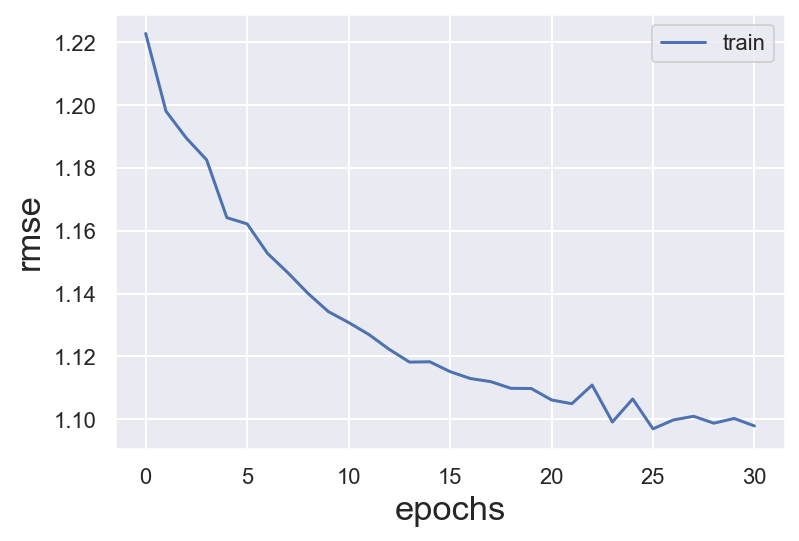

In [59]:
train_time= model.fit(X, X)

In [60]:
top_k, _ = model.recommend_k_items(X)

top_k_df = am.map_back_sparse(top_k, kind = 'prediction')

merged = pd.merge(train, top_k_df, on=["userID", "itemID"], how="outer")

all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)
all_predictions = all_predictions.sort_values(['userID','prediction'],ascending=False).groupby('userID').head(TOP_K).drop(columns=['timestamp', 'title'])

all_predictions.head()

,userID,itemID,prediction
84061,943,1539,4.735871
84063,943,1514,4.602206
84057,943,506,4.345236
84064,943,1433,4.309887
84056,943,269,4.303385


In [61]:
all_metrics['RBM'] = test_model_perfomance(all_predictions)

Рекомендации для пользователя: 96


,userID,itemID,prediction,title,genres
0,96,1207,4.872729,Jade (1995),Thriller
1,96,1391,4.819647,For Ever Mozart (1996),Drama
2,96,1443,4.807730,8 Seconds (1994),Drama
3,96,439,4.802153,Amityville: A New Generation (1993),Horror
4,96,1573,4.701944,Spirits of the Dead (Tre passi nel delirio) (1...,Horror
5,96,1441,4.698196,Moonlight and Valentino (1995),Drama|Romance
6,96,666,4.682882,Blood For Dracula (Andy Warhol's Dracula) (1974),Horror
7,96,1168,4.657100,Little Buddha (1993),Drama
8,96,1263,4.638546,Foxfire (1996),Drama
9,96,1367,4.602286,Faust (1994),Animation


Рекомендации для пользователя: 734


,userID,itemID,prediction,title,genres
0,734,1480,4.932339,Herbie Rides Again (1974),Adventure|Children's|Comedy
1,734,1207,4.929655,Jade (1995),Thriller
2,734,1514,4.920978,Dream With the Fishes (1997),Drama
3,734,18,4.827528,"White Balloon, The (1995)",Drama
4,734,666,4.746590,Blood For Dracula (Andy Warhol's Dracula) (1974),Horror
5,734,1600,4.699836,Guantanamera (1994),Comedy
6,734,1391,4.665770,For Ever Mozart (1996),Drama
7,734,1443,4.663630,8 Seconds (1994),Drama
8,734,1541,4.629218,"Beans of Egypt, Maine, The (1994)",Drama
9,734,1549,4.617214,Dream Man (1995),Thriller


## 2.7 Riemannian Low-rank Matrix Completion (RLRMC)*
Matrix factorization algorithm using Riemannian conjugate gradients optimization with small memory consumption.

In [62]:
from reco_utils.recommender.rlrmc.RLRMCdataset import RLRMCdataset 
from reco_utils.recommender.rlrmc.RLRMCalgorithm import RLRMCalgorithm 

In [63]:
# Model parameters

# rank of the model, a positive integer (usually small), required parameter
rank_parameter = 10
# regularization parameter multiplied to loss function, a positive number (usually small), required parameter
regularization_parameter = 0.001
# initialization option for the model, 'svd' employs singular value decomposition, optional parameter
initialization_flag = 'svd' #default is 'random'
# maximum number of iterations for the solver, a positive integer, optional parameter
maximum_iteration = 100 #optional, default is 100
# maximum time in seconds for the solver, a positive integer, optional parameter
maximum_time = 300#optional, default is 1000

# Verbosity of the intermediate results
verbosity=0 #optional parameter, valid values are 0,1,2, default is 0
# Whether to compute per iteration train RMSE (and test RMSE, if test data is given)
compute_iter_rmse=True #optional parameter, boolean value, default is False

In [64]:
data = RLRMCdataset(train=train)

In [65]:
model = RLRMCalgorithm(rank = rank_parameter,
                       C = regularization_parameter,
                       model_param = data.model_param,
                       initialize_flag = initialization_flag,
                       maxiter=maximum_iteration,
                       max_time=maximum_time)

In [66]:
model.fit(data,verbosity=verbosity)

In [67]:
users, items, preds = [], [], []
item = list(train.itemID.unique())
for user in train.userID.unique():
    user = [user] * len(item) 
    users.extend(user)
    items.extend(item)
    preds.extend(list(model.predict(user, item)))

all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)
all_predictions = all_predictions.sort_values(['userID','prediction'],ascending=False).groupby('userID').head(TOP_K).drop(columns=['timestamp', 'title'])

In [68]:
all_metrics['RLRM'] = test_model_perfomance(all_predictions)

Рекомендации для пользователя: 96


,userID,itemID,prediction,title,genres
0,96,100,5.191565,Fargo (1996),Crime|Drama|Thriller
1,96,150,5.145567,Swingers (1996),Comedy|Drama
2,96,324,5.066039,Lost Highway (1997),Mystery
3,96,902,5.038894,"Big Lebowski, The (1998)",Comedy|Crime|Mystery|Thriller
4,96,302,5.012943,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller
5,96,346,5.009825,Jackie Brown (1997),Crime|Drama
6,96,357,4.948669,One Flew Over the Cuckoo's Nest (1975),Drama
7,96,135,4.946912,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller
8,96,197,4.919735,"Graduate, The (1967)",Drama|Romance
9,96,495,4.917322,Around the World in 80 Days (1956),Adventure|Comedy


Рекомендации для пользователя: 734


,userID,itemID,prediction,title,genres
0,734,344,5.951389,"Apostle, The (1997)",Drama
1,734,374,5.267481,Mighty Morphin Power Rangers: The Movie (1995),Action|Children's
2,734,57,4.994986,Priest (1994),Drama
3,734,904,4.968125,Ma vie en rose (My Life in Pink) (1997),Comedy|Drama
4,734,394,4.936260,Radioland Murders (1994),Comedy|Mystery|Romance
5,734,457,4.883613,Free Willy 3: The Rescue (1997),Adventure|Children's|Drama
6,734,486,4.880161,Sabrina (1954),Comedy|Romance
7,734,262,4.823446,In the Company of Men (1997),Drama
8,734,863,4.792923,"Garden of Finzi-Contini, The (Giardino dei Fin...",Drama
9,734,916,4.744199,Lost in Space (1998),Action|Sci-Fi|Thriller


# 3. Самописные нейрорекоммендеры
Вспомогательный код:

In [69]:
from collections import defaultdict
import torch
import torch.nn.functional as F
from torch import distributions, nn, optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.distributions import Normal, Bernoulli, Independent

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from dataclasses import dataclass, fields

@dataclass
class Loss:
    full_loss: torch.Tensor

@dataclass
class VAELoss(Loss):
    kl_term: torch.Tensor
    reconstruction_term: torch.Tensor

def train_val_loop(model, dataloader, phase='train', optimizer=None):
    model.train(mode=(phase == 'train'))
    losses = defaultdict(list)
    total_losses = defaultdict(int)
    for x in dataloader:
        with torch.set_grad_enabled(phase == 'train'):
            loss = model.loss(x)
            if phase == 'train':
                optimizer.zero_grad()
                loss.full_loss.backward()
                optimizer.step()
            
            for loss_part in fields(loss):
                losses[loss_part.name].append(getattr(loss, loss_part.name).item())
                total_losses[loss_part.name] += getattr(loss, loss_part.name).item() * x.shape[0]
        
    for loss_part in total_losses:
        total_losses[loss_part] /= len(dataloader.dataset)

    return losses, total_losses


def train_model(model, train_loader, test_loader, epochs=20, lr=1e-1):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = defaultdict(list)

    _, test_avg_losses = train_val_loop(model, dataloader=test_loader, phase='eval')
    test_losses = {loss_part: [loss_value] for loss_part, loss_value in test_avg_losses.items()}

    for epoch in trange(epochs):
        train_loss, train_avg_loss = train_val_loop(model,
                                                    dataloader=train_loader,
                                                    phase='train',
                                                    optimizer=optimizer)

        test_loss, test_avg_loss = train_val_loop(model, dataloader=test_loader, phase='eval')

        for loss_part in train_loss:
            train_losses[loss_part].extend(train_loss[loss_part])
            test_losses[loss_part].append(test_avg_loss[loss_part])

        print(f"\rEpoch {epoch}, Train loss: {train_avg_loss['full_loss']:.4f}, Test loss: {test_avg_loss['full_loss']:.4f}", flush=True, end='')

    return train_losses, test_losses


def plot_vae_training_plot(train_losses, test_losses, title):
    elbo_train, recon_train, kl_train = train_losses[:, 0], train_losses[:, 1], train_losses[:, 2]
    elbo_test, recon_test, kl_test = test_losses[:, 0], test_losses[:, 1], test_losses[:, 2]
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, elbo_train, label='-elbo_train')
    plt.plot(x_train, recon_train, label='recon_loss_train')
    plt.plot(x_train, kl_train, label='kl_loss_train')
    plt.plot(x_test, elbo_test, label='-elbo_test')
    plt.plot(x_test, recon_test, label='recon_loss_test')
    plt.plot(x_test, kl_test, label='kl_loss_test')

    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

def save_training_plot(train_losses, test_losses, title):
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label='train loss')
    plt.plot(x_test, test_losses, label='test loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('loss')

# 3.1 VAE
Выбрал VAE в качестве `любой вариант из 1й лекции по нейрорекоммендерам`, т.к. хорошо проработанный вероятностный подход + похоже, иногда, действительно используют в рекомендациях  

Standard Variational Autoencoders (VAE) for Collaborative Filtering implementation.
* https://arxiv.org/pdf/1802.05814.pdf 
* https://arxiv.org/pdf/1808.01006.pdf

In [71]:
class FC_Encoder(nn.Module):
    def __init__(self, input_shape, latent_shape, dropout_p=0.5, hidden_shape=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(input_shape, hidden_shape),
            nn.SiLU(),
            nn.Linear(hidden_shape, hidden_shape),
            nn.SiLU()
        )
        self.to_mean = nn.Linear(hidden_shape, latent_shape)
        self.to_logvar = nn.Linear(hidden_shape, latent_shape)

    def forward(self, x):
        x = self.fc(x)
        return self.to_mean(x), self.to_logvar(x)

class FC_Decoder(nn.Module):
    def __init__(self, latent_shape, output_shape, hidden_shape=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_shape, hidden_shape),
            nn.SiLU(),
            nn.Linear(hidden_shape, output_shape),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.fc(x)

class FC_VAE(nn.Module):
    def __init__(self, input_shape, latent_shape, output_shape, dropout_p=0.3, hidden_shape=128):
        super().__init__()
        self.encoder = FC_Encoder(input_shape, latent_shape, dropout_p, hidden_shape)
        self.decoder = FC_Decoder(latent_shape, output_shape, hidden_shape)
        self.latent_shape = latent_shape
    
    def forward(self, x, is_train=True):
        x = F.normalize(x, p=2, dim=1)
        mu_z, logvar_z = self.encoder(x)
        
        logvar = logvar_z if is_train else torch.ones_like(logvar_z)
        qz_x = Independent(Normal(loc=mu_z, scale=torch.exp(logvar)), reinterpreted_batch_ndims=1)
        z = qz_x.rsample()

        decoded_x = self.decoder(z)
        return (mu_z, logvar_z), z, (decoded_x)
    

    def loss(self, x):
        (mu_z, logvar_z), z, (decoded_x) = self.forward(x)
        
        reconstruction_term = F.binary_cross_entropy(decoded_x, x) 

        batch_size, d = x.size(0), self.latent_shape
        pz = Independent(Normal(loc=torch.zeros(batch_size, d).to(device), scale=torch.ones(batch_size, d).to(device)), reinterpreted_batch_ndims=1)
        qz_x = Independent(Normal(loc=mu_z, scale=torch.exp(logvar_z)), reinterpreted_batch_ndims=1)
        kl_term = distributions.kl.kl_divergence(qz_x, pz).mean()
        
        full_loss = kl_term + reconstruction_term
        return VAELoss(full_loss=full_loss, kl_term=kl_term, reconstruction_term=reconstruction_term)
    
    @torch.no_grad()
    def recommend(self, x, k, remove_seen=True):
        self.eval()
        (mu_z, logvar_z), z, (score) = self.forward(x, is_train=False)
        
        if remove_seen:
            score[x > 0] = 0
            
        _, i = torch.topk(score, k, dim=1)
        return i

In [72]:
train_dataset = torch.from_numpy(user_item_csr.toarray()).float()
test_dataset = torch.from_numpy(user_item_test_csr.toarray()).float()

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Epoch 39, Train loss: 0.0994, Test loss: 0.0540


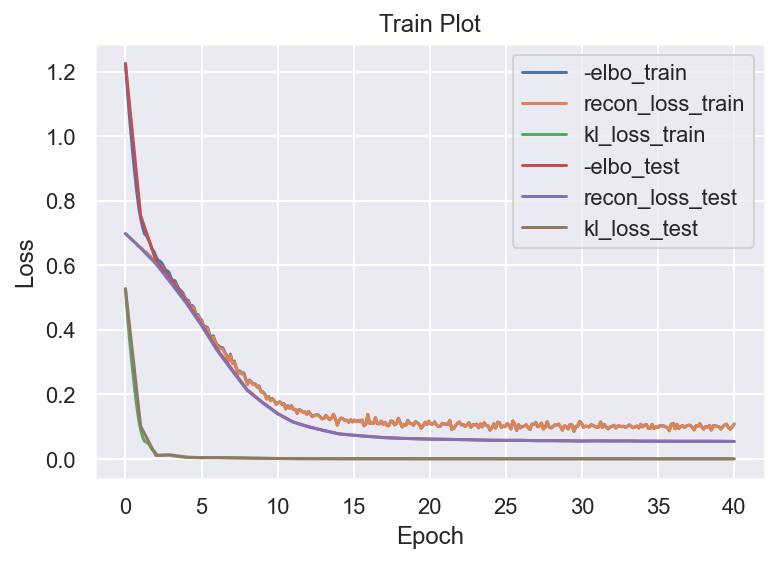

In [73]:
model = FC_VAE(input_shape=user_item_csr.shape[1], output_shape=user_item_csr.shape[1], latent_shape=128)
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=40, lr=1e-3)
train_losses = np.stack((train_losses['full_loss'], train_losses['reconstruction_term'], train_losses['kl_term']), axis=1)
test_losses = np.stack((test_losses['full_loss'], test_losses['reconstruction_term'], test_losses['kl_term']), axis=1)
plot_vae_training_plot(train_losses, test_losses, 'Train Plot')

In [74]:
ratings_predictions = model.recommend(train_dataset, k=TOP_K)

In [76]:
predictions = pd.DataFrame(np.arange(ratings_predictions.shape[0]), columns=['userID'])

predictions['itemID'] = ratings_predictions.tolist()

predictions = predictions[predictions['userID'].isin(train['userID'].unique())]

predictions = predictions.explode('itemID', ignore_index=True)

predictions['itemID'] = predictions['itemID'].astype(np.int64)

predictions['prediction'] = TOP_K - predictions.index % TOP_K

In [77]:
all_metrics['vae'] = test_model_perfomance(predictions)

Рекомендации для пользователя: 96


,userID,itemID,prediction,title,genres
0,96,100,10,Fargo (1996),Crime|Drama|Thriller
1,96,258,9,Contact (1997),Drama|Sci-Fi
2,96,181,8,Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
3,96,172,7,"Empire Strikes Back, The (1980)",Action|Adventure|Drama|Romance|Sci-Fi|War
4,96,286,6,"English Patient, The (1996)",Drama|Romance|War
5,96,1,5,Toy Story (1995),Animation|Children's|Comedy
6,96,7,4,Twelve Monkeys (1995),Drama|Sci-Fi
7,96,300,3,Air Force One (1997),Action|Thriller
8,96,288,2,Scream (1996),Horror|Thriller
9,96,313,1,Titanic (1997),Action|Drama|Romance


Рекомендации для пользователя: 734


,userID,itemID,prediction,title,genres
0,734,100,10,Fargo (1996),Crime|Drama|Thriller
1,734,127,9,"Godfather, The (1972)",Action|Crime|Drama
2,734,181,8,Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
3,734,258,7,Contact (1997),Drama|Sci-Fi
4,734,56,6,Pulp Fiction (1994),Crime|Drama
5,734,1,5,Toy Story (1995),Animation|Children's|Comedy
6,734,302,4,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller
7,734,79,3,"Fugitive, The (1993)",Action|Thriller
8,734,300,2,Air Force One (1997),Action|Thriller
9,734,237,1,Jerry Maguire (1996),Drama|Romance


## 3.2 Simple Attention
Решил использовать `Attentional factorization machines: Learning the weight of feature interactions via attention networks` ([arxiv](https://arxiv.org/abs/1708.04617))

![afm](https://deeptables.readthedocs.io/en/latest/_images/afm.png)

Сильно помогло negative sampling и [MarginRankingLoss](https://pytorch.org/docs/stable/generated/torch.nn.MarginRankingLoss.html#torch.nn.MarginRankingLoss)

In [791]:
class AttentionDataset(Dataset):
    def __init__(self, df, user_col='userID', item_col='itemID', rating_col='rating', n_negative=5, implicit_bound_value=4):
        df = df[df[rating_col] >= implicit_bound_value]
        self.items = df[[user_col, item_col]].values - 1
        self.n_items = df[item_col].max()
        self.positive = df.groupby(user_col)[item_col].apply(set)
        self.field_dims = np.max(self.items, axis=0) + 1
        self.n_negative = n_negative
    
    def __len__(self):
        return self.items.shape[0] * self.n_negative
    
    def __getitem__(self, i):
        i = i // self.n_negative
        positive_item = self.items[i]
        user_id = positive_item[0]
        
        while True:
            negative = torch.randint(self.n_items, (1,))
            if negative.item() not in self.positive[user_id + 1]:
                break
                
        return positive_item, torch.cat([torch.tensor([user_id]), negative])

In [792]:
class FeaturesEmbedding(torch.nn.Module):
    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(sum(field_dims), embed_dim)
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)

    def forward(self, x):
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return self.embedding(x)
    
class FeaturesLinear(torch.nn.Module):
    def __init__(self, field_dims, output_dim=1):
        super().__init__()
        self.fc = torch.nn.Embedding(sum(field_dims), output_dim)
        self.bias = torch.nn.Parameter(torch.zeros((output_dim,)))
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)

    def forward(self, x):
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return torch.sum(self.fc(x), dim=1) + self.bias
    
class AttentionalFactorizationMachine(torch.nn.Module):
    def __init__(self, embed_dim, attn_size, dropouts):
        super().__init__()
        self.attention = torch.nn.Linear(embed_dim, attn_size)
        self.projection = torch.nn.Linear(attn_size, 1)
        self.fc = torch.nn.Linear(embed_dim, 1)
        self.dropouts = dropouts

    def forward(self, x):
        num_fields = x.shape[1]
        row, col = list(), list()
        for i in range(num_fields - 1):
            for j in range(i + 1, num_fields):
                row.append(i), col.append(j)
        p, q = x[:, row], x[:, col]
        inner_product = p * q
        attn_scores = F.relu(self.attention(inner_product))
        attn_scores = F.softmax(self.projection(attn_scores), dim=1)
        attn_scores = F.dropout(attn_scores, p=self.dropouts[0], training=self.training)
        attn_output = torch.sum(attn_scores * inner_product, dim=1)
        attn_output = F.dropout(attn_output, p=self.dropouts[1], training=self.training)
        return self.fc(attn_output)
        
class AttentionalFactorizationMachineModel(torch.nn.Module):
    def __init__(self, field_dims, embed_dim, attn_size, dropouts, margin=0.4):
        super().__init__()
        self.num_fields = len(field_dims)
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.linear = FeaturesLinear(field_dims)
        self.afm = AttentionalFactorizationMachine(embed_dim, attn_size, dropouts)
        self.margin = margin

    def forward(self, x):
        x = self.linear(x) + self.afm(self.embedding(x))
        return torch.sigmoid(x.squeeze(1))

    def loss(self, x):
        p, n = x
        prob_pos = self.forward(p)
        prob_neg = self.forward(n)
        
        y = torch.ones(p.size(0))

        return Loss(full_loss=F.margin_ranking_loss(prob_pos, prob_neg, y, self.margin))  

In [793]:
train_dataset = AttentionDataset(train)
test_dataset = AttentionDataset(test)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [794]:
model = AttentionalFactorizationMachineModel(train_dataset.field_dims, embed_dim=64, attn_size=16, dropouts=(0.2, 0.2))
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=7, lr=1e-3)

Epoch 6, Train loss: 0.0686, Test loss: 0.1932


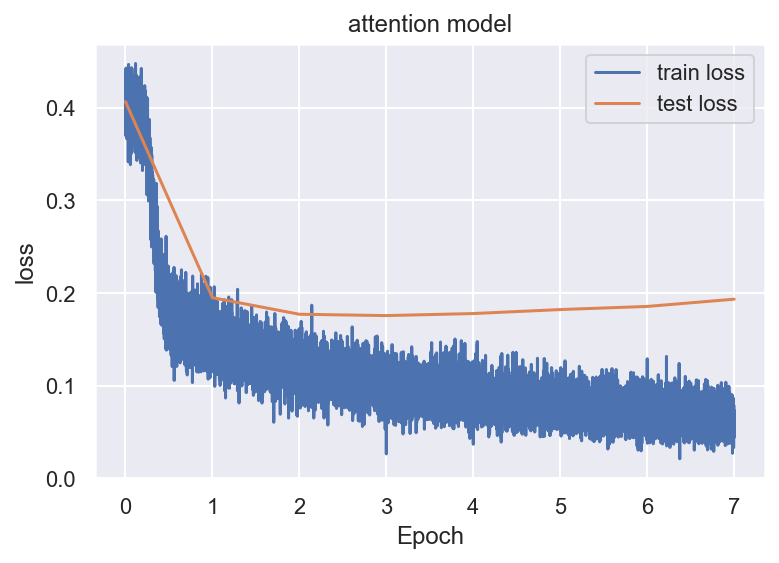

In [795]:
save_training_plot(train_losses['full_loss'], test_losses['full_loss'], 'attention model')

In [796]:
model.eval()
users, items, preds = [], [], []
item = torch.from_numpy(test.itemID.unique())
for user in test.userID.unique():
    a = torch.full((item.size(0),), user-1)
    t = torch.stack([a, item - 1], dim=1).view(-1, 2)
    with torch.no_grad():
        pred = model(t).detach().cpu().tolist()
    user = [user] * len(item) 
    users.extend(user)
    items.extend(item.tolist())
    preds.extend(pred)

In [797]:
all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)
all_predictions = all_predictions.sort_values(['userID','prediction'],ascending=False).groupby('userID').head(TOP_K).drop(columns=['timestamp', 'title'])

In [798]:
all_metrics['attention'] = test_model_perfomance(all_predictions)

Рекомендации для пользователя: 96


,userID,itemID,prediction,title,genres
0,96,100,0.999607,Fargo (1996),Crime|Drama|Thriller
1,96,258,0.999261,Contact (1997),Drama|Sci-Fi
2,96,181,0.999220,Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
3,96,172,0.997941,"Empire Strikes Back, The (1980)",Action|Adventure|Drama|Romance|Sci-Fi|War
4,96,168,0.997739,Monty Python and the Holy Grail (1974),Comedy
5,96,357,0.997390,One Flew Over the Cuckoo's Nest (1975),Drama
6,96,22,0.995818,Braveheart (1995),Action|Drama|War
7,96,12,0.995382,"Usual Suspects, The (1995)",Crime|Thriller
8,96,175,0.995356,Brazil (1985),Sci-Fi
9,96,176,0.994134,Aliens (1986),Action|Sci-Fi|Thriller|War


Рекомендации для пользователя: 734


,userID,itemID,prediction,title,genres
0,734,258,0.999996,Contact (1997),Drama|Sci-Fi
1,734,100,0.999946,Fargo (1996),Crime|Drama|Thriller
2,734,127,0.999945,"Godfather, The (1972)",Action|Crime|Drama
3,734,181,0.999939,Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
4,734,9,0.998598,Dead Man Walking (1995),Drama
5,734,1,0.997716,Toy Story (1995),Animation|Children's|Comedy
6,734,286,0.997444,"English Patient, The (1996)",Drama|Romance|War
7,734,7,0.996544,Twelve Monkeys (1995),Drama|Sci-Fi
8,734,216,0.995996,When Harry Met Sally... (1989),Comedy|Romance
9,734,168,0.995917,Monty Python and the Holy Grail (1974),Comedy


# 4. Оценка результатов

In [799]:
get_metrics(all_metrics)

,bpr_implicit,sar,fastai,LightGCN,NCF,RBM,RLRM,vae,attention
metric,,,,,,,,,
map_at_3,0.018115,0.032352,0.010448,0.022643,0.026860,0.000432,0.003299,0.013959,0.022239
ndcg_at_3,0.152451,0.249318,0.106708,0.186455,0.216609,0.009663,0.035925,0.121720,0.179269
precision_at_3,0.148266,0.241075,0.105338,0.181336,0.210322,0.009191,0.034995,0.117002,0.175680
recall_at_3,0.024761,0.043277,0.015415,0.030034,0.036203,0.000686,0.005009,0.019584,0.029557
map_at_5,0.023298,0.042180,0.013060,0.030340,0.036441,0.000523,0.004160,0.017483,0.028370
ndcg_at_5,0.145053,0.235561,0.099717,0.179121,0.209305,0.009614,0.036116,0.114993,0.172100
precision_at_5,0.139278,0.224390,0.095652,0.173065,0.202333,0.009332,0.035631,0.109014,0.167126
recall_at_5,0.038475,0.066342,0.022721,0.049493,0.058219,0.001071,0.008290,0.029123,0.045294
map_at_10,0.032231,0.059164,0.017142,0.042432,0.050507,0.000638,0.005679,0.022832,0.039248


Построим также *Average Treatment Effect* — насколько модели лучше/хуже, относительно базовой

In [800]:
get_ate(all_metrics, control_name='bpr_implicit')

,sar,fastai,LightGCN,NCF,RBM,RLRM,vae,attention
metric,,,,,,,,
map_at_3,1.423701,-0.766750,0.452777,0.874455,-1.768316,-1.481562,-0.415599,0.412366
ndcg_at_3,9.686625,-4.574335,3.400347,6.415817,-14.278874,-11.652643,-3.073092,2.681737
precision_at_3,9.280848,-4.292853,3.307006,6.205557,-13.907557,-11.327140,-3.126363,2.741435
recall_at_3,1.851668,-0.934589,0.527336,1.144266,-2.407495,-1.975112,-0.517670,0.479602
map_at_5,1.888141,-1.023803,0.704187,1.314304,-2.277541,-1.913838,-0.581509,0.507155
ndcg_at_5,9.050860,-4.533598,3.406795,6.425211,-13.543873,-10.893676,-3.005984,2.704712
precision_at_5,8.511211,-4.362596,3.378656,6.305485,-12.994621,-10.364717,-3.026435,2.784806
recall_at_5,2.786715,-1.575377,1.101762,1.974416,-3.740446,-3.018547,-0.935165,0.681859
map_at_10,2.693283,-1.508877,1.020157,1.827604,-3.159244,-2.655213,-0.939859,0.701731
